In [1]:
import inspect

def get_members(t):
    for m, n in inspect.getmembers(t):
        print(m)
        match n:
            case list() as l:
                for p in l:
                    print(f'     {p}')
            case dict() as d:
                for k, v in d.items():
                    print(f'     {k}: {v}')
            case _:
                print(f'     {n}')
                
                

In [2]:
from sympy import sympify, diff, Matrix, init_printing, Symbol, solve

init_printing()

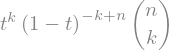

In [3]:
bernstein_polynomial = sympify('binomial(n, k) * t**k * (1 - t)**(n - k)')
bernstein_polynomial

In [4]:
for k in range(4):
    print(f"P_{k} = {bernstein_polynomial.subs({'n': 3, 'k': k})}")

P_0 = (1 - t)**3
P_1 = 3*t*(1 - t)**2
P_2 = 3*t**2*(1 - t)
P_3 = t**3


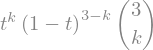

In [5]:
cubic_bernstein_polynomial = bernstein_polynomial.subs({'n': 3})
b3 = cubic_bernstein_polynomial
b3

In [6]:
def get_cubic_bernstein_polynomial(k):
    return b3.subs({'k': k})

for k in range(4):
    print(f'b_{k} = {get_cubic_bernstein_polynomial(k)}')

b_0 = (1 - t)**3
b_1 = 3*t*(1 - t)**2
b_2 = 3*t**2*(1 - t)
b_3 = t**3


In [7]:
p = [Symbol(f'P_{i}') for i in range(4)]
p

In [8]:
cubic_bezier = sum([b3.subs({'k': i}) * p[i] for i in range(4)])
print(cubic_bezier)
cubic_bezier

P_0*(1 - t)**3 + 3*P_1*t*(1 - t)**2 + 3*P_2*t**2*(1 - t) + P_3*t**3


In [9]:
d1cubic_bezier = diff(cubic_bezier, 't')
print(d1cubic_bezier)
d1cubic_bezier

-3*P_0*(1 - t)**2 + 3*P_1*t*(2*t - 2) + 3*P_1*(1 - t)**2 - 3*P_2*t**2 + 6*P_2*t*(1 - t) + 3*P_3*t**2


In [10]:
class Point():
    
    def __init__(self, x: float, y:float):
        self.x = x
        self.y = y
    
    def to_matrix(self):
        return Matrix([ self.x, self.y ])
    
    def __add__(self, other):
        match other:
            case Point():
                return Point(self.x + other.x, self.y + other.y)
            case _:
                raise TypeError
                
    def __sub__(self, other):
        match other:
            case Point():
                return Point(self.x - other.x, self.y - other.y)
            case _:
                raise TypeError
                
    def __str__(self):
        # return f'{self.x}, {self.y}'
        return self.__repr__()
    
    
    def __repr__(self):
        return f'{self.__class__.__name__}(x = {self.x}, y={self.y})'
                

In [11]:
import io

from collections.abc import Generator, Iterator
from functools import partial
from itertools import chain, pairwise
from pprint import pprint

import lxml.etree as etree
import pyperclip
import regex

from more_itertools import chunked, flatten

from toolz.functoolz import compose_left, curry, pipe
from toolz import curried


In [12]:
NSMAP = { None: 'http://www.w3.org/2000/svg', 
         'xlink': 'http://www.w3.org/1999/xlink' }

COMMAND_RE = regex.compile(r'''(?ix)(?P<command>[clmsvz])
                               (\s+(?P<arg>-?\d+(\.d+)?))*''')



In [13]:
def get_element_string(e):
    ''' returns the string representation of the an XML element 
        and its children
    '''
    match e:
        case etree.ElementBase:
            return etree.tostring(e, pretty_print=True).decode('utf-8')
        case _:
            print(e)

print_element = compose_left(get_element_string, print)



In [14]:
def read_elements(filename='./svg/notes_only_formatted.svg'):
    ''' For the given svg file, read all group elements (`g`) that are direct
        children of any `defs` elements.
    '''
    root = etree.parse(filename).getroot()
    return root.findall('.//defs/g', NSMAP)

def eliminate_whitespace(input):
    return regex.sub(r'(?<=\s)\s+', '', input)

def print_elements(elements):
    for element in elements:
        print(eliminate_whitespace(get_element_string(element)))
    
pipe(read_elements(), print_elements)

    

<Element {http://www.w3.org/2000/svg}g at 0x112a74580>


TypeError: expected string or buffer

In [ ]:
import operator

def get_paths(element):
    return list(element.findall('path', NSMAP))

path_defs = pipe(read_elements(), 
                 curried.map(get_paths),
                 flatten,
                 curried.map(lambda e: e.attrib['d']),
                 curried.map(eliminate_whitespace),
                 list)

path_defs

with open('path_defs.txt', encoding='utf-8', mode='w') as fp:
    for path_def in path_defs:
        print(path_def, file=fp)

In [ ]:
def parse_arg_strings(arg_strings):
    args = [float(arg) for arg in arg_strings]
    for i in range(0, len(args), 2):
        yield Point(args[i], args[i+1])

def parse_path_def(path_def):
    ''' For a path definition, that is the `d` parameter of an svg `path`
        element, return a dictionary for each command with the corresponding
        arguments, if any.
    '''
    for m in COMMAND_RE.finditer(path_def):
        d = m.capturesdict()
        command = d['command'][0]
        args = d['arg']
        if args:
            yield {'command': command,
                    'args': list(parse_arg_strings(args))}
        else:
            yield {'command': command}

        
def get_path_defs(template):
    ''' return the value of the path definition attribute `d`
        for the first path element found in the template element parameter
    '''
    return (e.attrib['d'] for e in template.findall('path', NSMAP))
    


# path_def_list = []

# template_count = 0
# for template in read_elements():
#     path_defs = list(get_path_defs(template))
#     print(f'There are {len(path_defs)} path_defs')
#     for path_def in path_defs:
#         template_count += 1
#         print(template_count)
        
#         if template_count == 5:
#             print_element(path_def)
        
#         # print(regex.sub(r'(?<=\s)\s+', '', path_def))
#         print()
#         path_def_list.append(list(parse_path_def(path_def)))
#         pprint(path_def_list[-1])
#         print()

In [ ]:
def get_points(commands):
    for command in commands:
        if 'args' in command:
            yield {'command': command['command'], 
                   'args': [Point(*arg) for arg in command['args']]}
        else:
            yield command
            

commands_in_point_form = list(get_points(path_def_list))
pprint(commands_in_point_form)

In [ ]:
# [Point(*arg) for arg in commands_in_point_form[0][0]['args']]

In [36]:
p0 = commands_in_point_form[0][0]['args'][0]
p1 = commands_in_point_form[0][1]['args'][0] + p0
p2 = commands_in_point_form[0][1]['args'][1] + p0
p3 = commands_in_point_form[0][1]['args'][2] + p0

p0.to_matrix(), p1.to_matrix(), p2.to_matrix(), p3.to_matrix()



IndexError: list index out of range

In [ ]:
def get_points(p0, control_points):
    yield p0
    for p in control_points:
        yield p0 + p
        
vectors = [pt.to_matrix() for pt 
           in get_points(commands_in_point_form[0][0]['args'][-1], 
                         commands_in_point_form[0][1]['args'])]
vectors


In [ ]:
substitution_dict = {f'P_{i}':v for i, v in enumerate(vectors)}
substitution_dict


In [ ]:
b = cubic_bezier.subs(substitution_dict)
b


In [ ]:
d1b = d1cubic_bezier.subs(substitution_dict)
d1b


In [ ]:
t = Symbol('t')


In [ ]:
# Find t when the derivative of the curve w.r.t. t = 0.
# First, we set the first derivative of the parametric equation for x = 0 to
# determine its tangent.
d1bx = d1b.row(0)
solutions = [soln[t] for soln in solve(d1bx) 
             if soln[t] >= 0.0 and soln[t] <= 1.0]
print('Value of t when x = 0: ', end='')
pprint(solutions)

print('Tangent points:')
for solution in solutions:
    pprint(b.subs(t, solution))
    

In [ ]:
# Rewriting the above in a form that's easier to use in code:
d1bx = d1b.row(0)
solutions = (soln[t] for soln in solve(d1bx)
             if soln[t] >= 0.0 and soln[t] <= 1.0)
vertical_tangent_points = [b.evalf(subs={t: solution}) for solution in solutions]
vertical_tangent_points


In [ ]:
vertical_tangent_points[0][0], vertical_tangent_points[0][1]


In [ ]:
d1by = d1b.row(1)
solutions = (soln[t] for soln in solve(d1by)
             if soln[t] >= 0.0 and soln[t] <= 1.0)
horizontal_tangent_points = [b.evalf(subs={t: solution}) for solution in solutions]
horizontal_tangent_points


In [ ]:
from IPython.core.display import HTML

HTML(f'''<svg viewbox="0 0 700 600">
<rect width="700" height="600" fill="#fff"/>
<g transform="translate(350, 300) scale(.5, .5)">
<line x1="0" y1="-550" x2="0" y2="550" stroke="#000"/>
<line x1="-650" y1="0" x2="650" y2="0" stroke="#000"/>
<g id="note-0" transform="scale(1, 1)">
            <path d="M 213 112
                     c -45 0 -69 -34 -69 -88
                     c 0 -102 89 -136 134 -136
                     s 69 34 69 88
                     c 0 102 -89 136 -134 136
                     z
                     M 245 136
                     c 144 0 246 -65 246 -136
                     s -102 -136 -246 -136
                     s -245 65 -245 136
                     s 101 136 245 136
                     z"/>
        </g>
        </g>
</svg>''')


In [ ]:
import abc

@dataclass(frozen=True)
class MoveTo():
    p: Point
    
    def __str__(self):
        return f'M {self.p}'
    
@dataclass(frozen=True)
class AbstractCubicBezier(abc.ABC):
    p0: Point
    p1: Point
    p2: Point
    p3: Point
 
    @property
    def points(self):
        return [self.p0, self.p1, self.p2, self.p3]

@dataclass(frozen=True)
class CubicBezierAbs(AbstractCubicBezier):
    
    def to_rel(self):
        return CubicBezierRel(MoveTo(self.p0), 
                              self.p1 - self.p0, 
                              self.p2 - self.p0, 
                              self.p3 - self.p0)
    
    def __str__(self):
        return f'C {self.p1} {self.p2} {self.p3}'

@dataclass(frozen=True, init=False)
class CubicBezierRel(AbstractCubicBezier):
    
    def __init__(self, move_to, p1, p2, p3):
        match move_to:
            case Point() as p:
                super().__init__(p, p1, p2, p3)
            case MoveTo():
                super().__init__(move_to.p, p1, p2, p3)
            case CubicBezierAbs() as b:
                super().__init__(b.p3, p1, p2, p3)
        
    def to_abs(self):
        return CubicBezierAbs(self.p0, 
                              self.p1 + self.p0, 
                              self.p2 + self.p0, 
                              self.p3 + self.p0)
        
    def __str__(self):
        return f'c {self.p1} {self.p2} {self.p3}'

    
@dataclass(frozen=True)
class ShorthandCubicBezierRel(CubicBezierRel):
    
    def __init__(self, previous_bezier, p2, p3):
        super().__init__(previous_bezier.p3,
                              previous_bezier.p3 - previous_bezier.p2,
                              p2,
                              p3)
    
    def __str__(self):
        return f's {self.p2} {self.p3}'
    
class ClosePath():
    
    def __str__(self):
        return 'z'
    
    def __repr__(self):
        return f'{self.__class__.__name__}()'


for cmd in commands_in_point_form:
    pprint(cmd)
    

In [ ]:
import json
with open('whole_note_path.json', mode='w') as fp:
    json.dump(get_commands(), fp, indent=4)
    

In [ ]:
def make_typed_commands(command_dicts):
    previous_command = None
    for d in command_dicts:
        match d['command']:
            case 'M':
                move_to = MoveTo(d['args'][0])
                previous_command = move_to
                yield move_to
            case 'c':
                rel_bezier = CubicBezierRel(previous_command, *d['args'])
                abs_bezier = rel_bezier.to_abs()
                previous_command = abs_bezier
                yield abs_bezier
            case 's':
                rel_bezier = ShorthandCubicBezierRel(previous_command, *d['args'])
                abs_bezier = rel_bezier.to_abs()
                yield abs_bezier
            case 'z':
                previous_command = None
                yield ClosePath()
                
all_typed_commands = [list(make_typed_commands(c)) for c in commands_in_point_form]
pprint(all_typed_commands)




In [ ]:
typed_commands = all_typed_commands[0]
with io.StringIO() as sp:
    for cmd in typed_commands:
        print(cmd, file=sp)
    s = sp.getvalue()
    
print(s)
pyperclip.copy(s)


In [ ]:
def parse_attr_dict(attr_dict):
    with io.StringIO() as sp:
        for key, value in attr_dict.items():
            print(f' {key}="{value}"', end='', file=sp)
        return sp.getvalue()

def line(x1, y1, x2, y2, attr={}):
    
    return f'<line x1="{x1}" y1="{y1}" x2="{x2}" ' \
           f'y2="{y2}"{parse_attr_dict(attr)}/>'

def horizontal_line(x1, x2, y, attr={}):
    return line(x1, y, x2, y, attr=attr)

def vertical_line(x, y1, y2, attr={}):
    return line(x, y1, x, y2, attr=attr)

def get_grid_lines(min_x, min_y, max_x, max_y, incr, start_offset=-25):
    for y in range(min_x, max_x+incr, incr):
        yield horizontal_line(min_x+start_offset, max_x, y)
    for x in range(min_y, max_y+incr, incr):
        yield vertical_line(x, min_y+start_offset, max_y)
        
def get_axes(min_x, min_y, max_x, max_y):
    attr = {'class': 'axis'}
    if min_x <= 0 and max_x >= 0:
        yield horizontal_line(min_x, max_x, 0, attr)
    if min_y <= 0 and max_y >= 0:
        yield vertical_line(0, min_y, max_y, attr)
        
def svg(content, viewbox='"0 0 700 600"'):
    return f'''<svg viewbox={viewbox}>
               <g transform="translate(25, 25)">
               <rect width="700" height="600" class="bounding-rectangle" 
                stroke="#000" stroke-width="1" fill="#fff"/>
                {content}</g></svg>'''

grid_lines ='\n'.join(chain(get_grid_lines(0, 300, 650, 250, 100),
                            get_axes(-25, -325, 650, 250)))

grid = f'<g>{grid_lines}</g>'

svg_doc = svg(grid)

# print(svg_doc)

# grid_tree = etree.XML(svg_doc)
# pprint(etree.tostring(grid_tree, pretty_print=True).decode('utf-8'))

HTML(svg_doc)
pyperclip.copy(svg_doc)


In [ ]:
s = '\n'.join(f'<text x="{i-9}" y="-10" class="axis-label">{i}</text>'
         for i in range(200, 700, 100))
pyperclip.copy(s)
print(s)


In [ ]:
s = '\n'.join(f'<text x="-25" y="{i+3}">{i}</text>'
              for i in range(-300, 0, 100))
pyperclip.copy(s)
print(s)

In [ ]:
s = '\n'.join(f'<line x1="-25" y1="{i}" x2="650" y2="{i}"/>'
              for i in range(-300, 0, 100))
pyperclip.copy(s)
print(s)


In [ ]:
for t in typed_commands[1:3]:
    print(t)
    

In [ ]:
with io.StringIO() as fp:
    for t in typed_commands[:2]:
        match t:
            case CubicBezierAbs() as b:
                print(f'{b.to_rel()}', file=fp)
            case _:
                print(f'{t}', file=fp)
    s = fp.getvalue()
    
as_path = f'<path d=\"{" ".join(line.strip() for line in s.splitlines())}\" class="special"/>'
print(as_path)
pyperclip.copy(as_path)

In [ ]:
RAW_CMD_RE = regex.compile(r'(?ix)[clmsvz](\s+(-?\d+(\.d+)?))*')

def reformat_path_def(path_def, leader_size=30):
    leader = ' ' * leader_size
    return '\n'.join(f'{leader}{m[0]}' for m in RAW_CMD_RE.finditer(path_def))

print(reformat_path_def('M 213 112                 c -45 0 -69 -34 -69 -88                 c 0 -102 89 -136 134 -136                 s 69 34 69 88                 c 0 102 -89 136 -134 136                 z                 M 245 136                 c 144 0 246 -65 246 -136                 s -102 -136 -246 -136                 s -245 65 -245 136                 s 101 136 245 136                 z', leader_size=0))

In [ ]:
import typing

class CoordinatePair(typing.NamedTuple):
    x: int
    y: int
    
    def __str__(self):
        return f' {self.x}, {self.y}'
        
    def __repr__(self):
        return f'{self.__class__.__name__}(x={self.x}, y={self.y})'
    
    def __add__(self, other):
        return CoordinatePair(self.x + other.x, self.y + other.y)
    
    def __sub__(self, other):
        return CoordinatePair(self.x - other.x, self.y - other.y)
    
    def __rmul__(self, other):
        match other:
            case int() | float() as p:
                return CoordinatePair(p * self.x, p * self.y)
            case _:
                raise TypeError
    
class SimpleCommand():
    
    def __init__(self, command, coordinates: list[CoordinatePair]):
        
        match command:
            case list() as l:
                self.command = l[0]
            case _:
                self.command = command
                
        self.coordinates = coordinates
    
    def __str__(self):
        with io.StringIO() as sp:
            prints = partial(print, file=sp)
            prints(self.command, end='     ')
            if self.coordinates:
                for coordinate in self.coordinates:
                    prints(coordinate)
                    prints('      ', end='')
            return sp.getvalue()
        
    def __repr__(self):
        with io.StringIO() as sp:
            prints = partial(print, end='', file=sp)
            prints(f'{self.__class__.__name__}(command="{self.command}", ')
            prints('coordinates=[')
            coordinates_str = ', '.join([f'{pair!r}' for pair 
                                         in self.coordinates])
            prints(f'{coordinates_str}]')
            return sp.getvalue()
                
                
def parse_coordinates(coordinate_str):
    if not s:
        return
    return CoordinatePair(*(int(s) for s in coordinate_str.split()))

def parse_command(capturesdict) -> SimpleCommand:
    return SimpleCommand(command=capturesdict['command'][0], 
                         coordinates=[parse_coordinates(c) for c 
                                      in capturesdict['coordinates']])

CMD_WITH_PAIRED_ARGS_RE = \
    regex.compile(r'(?ix)(?P<command>[clmsvz])'
                  r'(\s+(?P<coordinates>'
                  r'    -?\d+(\.\d+)?'
                  r'\s+'
                  r'    -?\d+(\.\d+)?'
                  r'))*')

def get_simple_commands(s: str) -> Generator[SimpleCommand]:
    for m in CMD_WITH_PAIRED_ARGS_RE.finditer(s):
        d = m.capturesdict()
        parsed_command = parse_command(d)
        yield parsed_command

def get_abs_cubic_beziers(commands: Iterator[SimpleCommand]) \
        -> Generator[list[CoordinatePair]]:
    for cmd in commands:
        match cmd.command:
            case 'M':
                start_point = cmd.coordinates[0]
            case 'c':
                control_points = \
                    [start_point] + \
                    [start_point + coordinate for coordinate in cmd.coordinates]
                start_point = control_points[-1]
                previous_bezier = control_points
                yield control_points
            case 's':
                control_points = [start_point] \
                               + [2 * start_point - previous_bezier[2]] \
                               + [start_point + coordinate 
                                  for coordinate in cmd.coordinates]
                start_point = control_points[-1]
                previous_bezier = control_points
                yield control_points
            case 'z':
                start_point = []
                previous_bezier = []

def get_paths_from_control_points(control_points):
    ''' Use this method to generate path statements for
        verifying that the conversion of relative coordinates
        to absolute coordinates has been successful. '''
    
    s = f'<path d="M {control_points[0]!s} C '
    for cp in control_points[1:4]:
        s += f'{cp!s} '
    s = s.strip() + '" class="absolute"/>'
    return s.strip()
                
get_control_points = compose_left(get_simple_commands, 
                                  get_abs_cubic_beziers,
                                  list)
    
# beziers = pipe(s, get_simple_commands, get_abs_cubic_beziers, list)

# for control_points in beziers:
#     print(get_paths_from_control_points(control_points))




In [ ]:
defs = read_templates()
for def_ in defs:
    print_element(def_)

In [ ]:
cat /Users/richard/Repos/note_hierarchy/svg/notes_only_formatted.svg

In [ ]:
s = 'M 213 112                 c -45 0 -69 -34 -69 -88                 c 0 -102 89 -136 134 -136                 s 69 34 69 88                 c 0 102 -89 136 -134 136                 z                 M 245 136                 c 144 0 246 -65 246 -136                 s -102 -136 -246 -136                 s -245 65 -245 136                 s 101 136 245 136                 z'

for cmd in get_simple_commands(s):
    print(cmd)
